## 1 - Introdução

#### Objetivo: Criar um modelo preditivo que classifique pacientes de mamografia como maligno(yes) ou benigno(no). 
#### Modelo de Machine Learning utilizado: Support Vector Machine (SVM) - (modelo supervisionado e de classificação)


- A mamografia é o método mais eficaz para a triagem do câncer de mama disponível hoje. Entretanto, o baixo valor preditivo positivo da biópsia resultante da interpretação da mamografia, leva a aproximadamente 70% de biópsias desnecessárias com resultados benignos. Para reduzir o alta número de biópsias desnecessárias da mama, vários diagnósticos auxiliados por computador foram propostos nos últimos anos.Estes sistemas ajudam os médicos na sua decisão de realizar uma biópsia em uma suspeita lesão observada em uma mamografia. Esse dataset pode ser usado para prever a gravidade (benigna ou maligna) de uma lesão de massa mamográfica a partir dos atributos BI-RADS e a idade do paciente. Ele contém uma avaliação do BI-RADS, a idade do paciente e três atributos do BI-RADS, juntamente com a classe (o campo de severidade), sendo 516 casos benignos e 445 malignos que foram identificadas em mamografias digitais de campo completo coletados no Instituto de Radiologia da Universidade Erlangen-Nuremberg entre 2003 e 2006. Cada instância possui uma avaliação BI-RADS associada que varia de 1 (definitivamente benigna) a 5 (altamente sugestivo de malignidade), atribuído em um processo de revisão de dois médicos. 


- Cada coluna do dataset pode ser descrita por:
Bi-rads, Age, Shape, Margin, Density, Severity.        


- O conjunto de dados original foi baixado do repositório UCI ML:
https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass

## 2 - Importando os pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipy_table as tbl
import warnings
import sklearn.metrics as metrics

from plot_metric.functions import BinaryClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")
sns.set_style ("whitegrid")
%matplotlib inline

In [2]:
df = pd.read_csv("mammographic.csv", header=None)

## 3 - Data wrangling

In [3]:
df.head()

,0,1,2,3,4,5
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [4]:
df.columns = ["Bi-rads", "Age", "Shape", "Margin", "Density", "Severity"]

In [5]:
df.head()

,Bi-rads,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
Bi-rads     961 non-null object
Age         961 non-null object
Shape       961 non-null object
Margin      961 non-null object
Density     961 non-null object
Severity    961 non-null int64
dtypes: int64(1), object(5)
memory usage: 26.3+ KB


In [7]:
df.describe()

,Severity
count,961.000000
mean,0.463059
std,0.498893
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
df = df.apply(pd.to_numeric, errors='coerce') #pd para numérico
df.describe()

,Bi-rads,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


In [9]:
df.isnull().values.any()

True

In [10]:
df.isnull().sum()

Bi-rads      2
Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [11]:
#substituindo os valores ? por NaN
data = df.replace('?', np.nan, inplace=True)
data=df
df.head()

,Bi-rads,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


#### Verificando as métricas

In [12]:
for column_name in df.columns:
    print(
        """{column_name}:
        {unique_values}""".format(
            column_name=column_name,
            unique_values=", ".join(
                map(str, df[column_name].unique())
            ),
        )
    )
    
print(
    """
NUMBER OF EXAMPLES:{}
NUMBER OF COLUMNS: {}
""".format(
        df.shape[0], df.shape[1]
    )
)

Bi-rads:
        5.0, 4.0, 3.0, nan, 2.0, 55.0, 0.0, 6.0
Age:
        67.0, 43.0, 58.0, 28.0, 74.0, 65.0, 70.0, 42.0, 57.0, 60.0, 76.0, 64.0, 36.0, 54.0, 52.0, 59.0, 40.0, 66.0, 56.0, 75.0, 63.0, 45.0, 55.0, 46.0, 39.0, 81.0, 77.0, 48.0, 78.0, 50.0, 61.0, 62.0, 44.0, 23.0, 80.0, 53.0, 49.0, 51.0, 25.0, 72.0, 73.0, 68.0, 33.0, 47.0, 29.0, 34.0, 71.0, 84.0, 24.0, 86.0, 41.0, 87.0, 21.0, 19.0, 35.0, 37.0, 79.0, 85.0, 69.0, 38.0, 32.0, 27.0, 83.0, 88.0, 26.0, 31.0, nan, 18.0, 82.0, 93.0, 30.0, 22.0, 96.0, 20.0
Shape:
        3.0, 1.0, 4.0, nan, 2.0
Margin:
        5.0, 1.0, nan, 4.0, 3.0, 2.0
Density:
        3.0, nan, 1.0, 2.0, 4.0
Severity:
        1, 0

NUMBER OF EXAMPLES:961
NUMBER OF COLUMNS: 6



#### O número 55.0 foi digitado errado pelo editor do dataset, pois está fora do range especificado que vai de 0.0 a 6.0 na coluna Bi-rads. Provavelmente ele quis digitar "5.0", então substituirei o valor.

In [13]:
df["Bi-rads"].loc[df['Bi-rads'] == 55.0] # encontrar a linha

340    55.0
Name: Bi-rads, dtype: float64

In [14]:
df["Bi-rads"].loc[df['Bi-rads'] == 55.0] = 5.0 #substituir por 5.0

In [15]:
df["Bi-rads"].value_counts()

4.0    547
5.0    346
3.0     36
2.0     14
6.0     11
0.0      5
Name: Bi-rads, dtype: int64

#### Eliminando as missing values

A coluna Bi-rads tem apenas duas linhas com missing value que foram substituídas por 4, valor mais presente.

As missing values da idade (5 linhas) foram substituídas com a média.

In [16]:
df['Bi-rads'] = df['Bi-rads'].fillna(4) 

df['Age'] = df['Age'].fillna(df['Age'].median())

As missing values do Shape(31 linhas), Margin(48 linhas) e Density(76 linhas) foram substituídas com a média dessas respectivas colunas, passando como parâmetro as médias das colunas Bi-rads e Severity. Essa é uma forma mais segura de fidelizar os valores faltantes. Por fim, esse valores de classificação foram arredondados.

In [17]:
missing_Shapes = df[df['Shape'].isnull()]
# determinando a média baseado no sexo e classe
mean_Shapes = df.groupby(['Bi-rads','Severity'])['Shape'].mean()

def media_shape(row):

    if pd.isnull(row['Shape']):
        return mean_Shapes[row['Bi-rads'],row['Severity']]
    else:
        return row['Shape']

df['Shape'] =df.apply(media_shape, axis=1)

In [18]:
missing_Margin = df[df['Margin'].isnull()]
# determinando a média baseado no sexo e classe
mean_Margin = df.groupby(['Bi-rads','Severity'])['Margin'].mean()

def media_margin(row):

    if pd.isnull(row['Margin']):
        return mean_Margin[row['Bi-rads'],row['Severity']]
    else:
        return row['Margin']

df['Margin'] =df.apply(media_margin, axis=1)

In [19]:
missing_Density = df[df['Density'].isnull()]
# determinando a média baseado no sexo e classe
mean_Density = df.groupby(['Bi-rads','Severity'])['Density'].mean()

def media_density(row):

    if pd.isnull(row['Density']):
        return mean_Density[row['Bi-rads'],row['Severity']]
    else:
        return row['Density']

df['Density'] =df.apply(media_density, axis=1)

In [20]:
# arredondar valores
df["Shape"] = df["Shape"].round()
df["Margin"] = df["Margin"].round()
df["Density"] = df["Density"].round()

In [21]:
df.head(10)

,Bi-rads,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,3.0,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,3.0,1
5,4.0,65.0,1.0,2.0,3.0,0
6,4.0,70.0,2.0,2.0,3.0,0
7,5.0,42.0,1.0,4.0,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
9,5.0,60.0,4.0,5.0,1.0,1


In [22]:
df.isnull().values.any()

True

Aqui foi identificada uma linha faltando ainda na coluna Density. 

In [23]:
df.isnull().sum()

Bi-rads     0
Age         0
Shape       0
Margin      0
Density     1
Severity    0
dtype: int64

In [24]:
missing = df[df['Density'].isnull()]  #encontrando a linha
missing

,Bi-rads,Age,Shape,Margin,Density,Severity
212,2.0,59.0,1.0,1.0,NaN,1


In [25]:
table = pd.crosstab(df['Bi-rads'],df['Severity'])
print (table)

Severity    0    1
Bi-rads           
0.0         2    3
2.0        13    1
3.0        30    6
4.0       428  121
5.0        40  306
6.0         3    8


Identifiquei que o sistema não preencheu essa coluna porque só tem uma pessoa com Bi-rads(2.0) e Severity(1.0), justamente
o valor faltante. Por isso vou substituir
esse valor faltando por 3.0 (valor mais presente).

In [26]:
df['Density'] = df['Density'].fillna(3) 

In [27]:
df.isnull().values.any()

False

## 4 - Data analysis

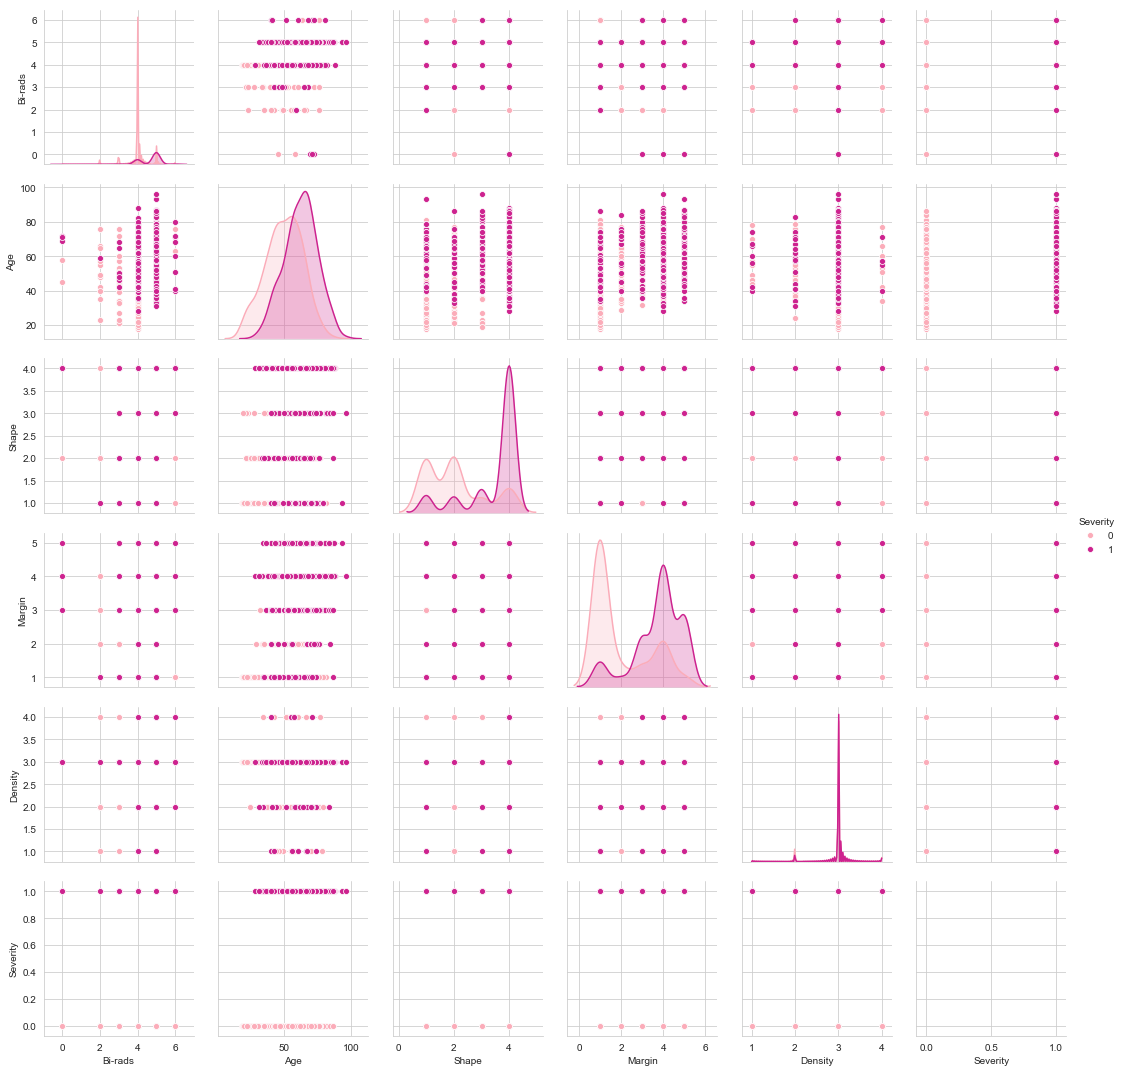

In [28]:
sns.pairplot (data=df, palette="RdPu", hue="Severity")

0    516
1    445
Name: Severity, dtype: int64

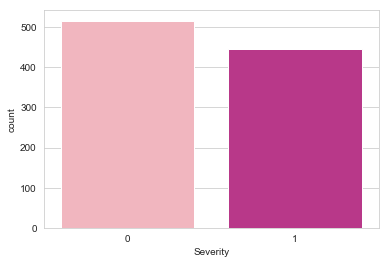

In [29]:
sns.countplot ("Severity", data=df, palette="RdPu")
df["Severity"].value_counts()

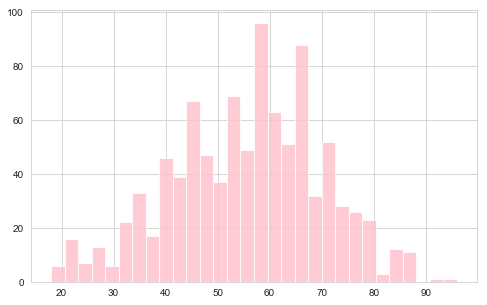

In [30]:
plt.figure(figsize=(8,5))
df["Age"].hist(bins=30, color="pink", alpha=0.8)

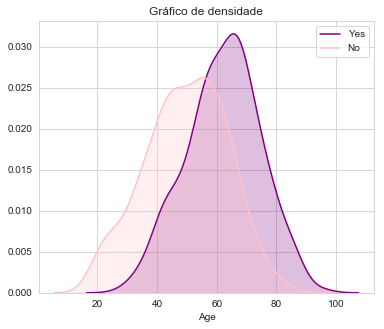

In [31]:
plt.figure(figsize=(6,5))
sns.kdeplot(df["Age"][df.Severity == 1], color="purple", shade=True)
sns.kdeplot(df["Age"][df.Severity == 0], color="pink", shade=True)
plt.legend(['Yes', 'No'])
plt.title('Gráfico de densidade')
plt.xlabel ("Age")
plt.show()

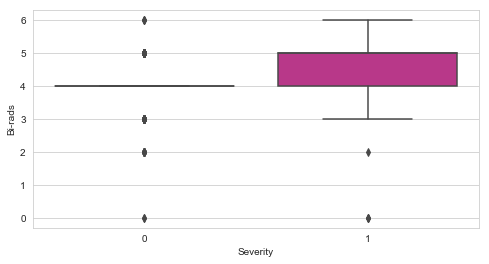

In [32]:
plt.figure (figsize=(8,4))
sns.boxplot (x="Severity", y="Bi-rads",data=df, palette="RdPu")

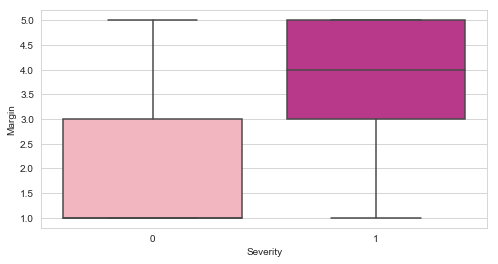

In [33]:
plt.figure (figsize=(8,4))
sns.boxplot (x="Severity", y="Margin",data=df, palette="RdPu")

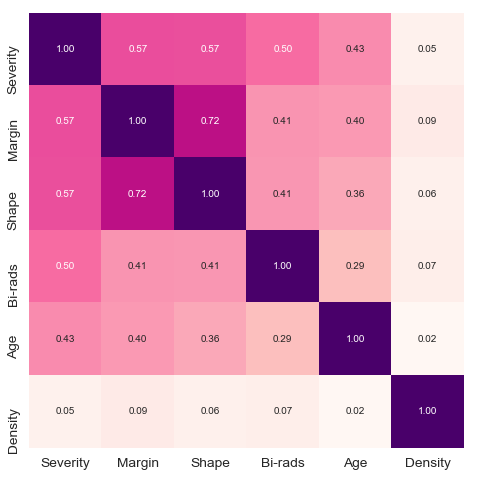

In [34]:
k = 6 #número de variáveis para o heatmap
corrmat = df.corr() #correlação
cols = corrmat.nlargest(k, 'Severity')['Severity'].index
tab = np.corrcoef(df[cols].values.T) 

plt.figure(figsize=(8,8))
sns.set(font_scale=1.25)
sns.heatmap(tab, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values, cmap="RdPu")
plt.show()

## 5 - Machine learning (Support Vector Machine - SVM)

#### Dividindo os dados entre treino e test

In [35]:
X = df.drop("Severity", axis=1)
y = df["Severity"]

In [36]:
X_train, X_test, y_train, y_test = train_test_split (X,y, test_size=0.30, random_state=5)

#### Aplicando o modelo e fazendo a predição

In [37]:
svc = SVC()

In [38]:
svc.fit (X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [39]:
prediction = svc.predict(X_test)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
print (classification_report(y_test,prediction))
print("\n")
print (confusion_matrix(y_test,prediction))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       158
           1       0.79      0.79      0.79       131

    accuracy                           0.81       289
   macro avg       0.81      0.81      0.81       289
weighted avg       0.81      0.81      0.81       289



[[130  28]
 [ 27 104]]


Tentando melhorar a acurácia com o GridSearchCV

In [42]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 
grid = GridSearchCV(SVC(),param_grid,refit=True)

In [43]:
grid.fit (X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [44]:
prediction_grid = grid.predict(X_test)

In [45]:
print (classification_report(y_test,prediction_grid))
print("\n")
print (confusion_matrix(y_test,prediction_grid))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       158
           1       0.83      0.76      0.79       131

    accuracy                           0.82       289
   macro avg       0.82      0.81      0.82       289
weighted avg       0.82      0.82      0.82       289



[[138  20]
 [ 32  99]]


#### A acurácia do modelo passou de 81% para 82% com o GridSearchCV.

## 6 - Resultados

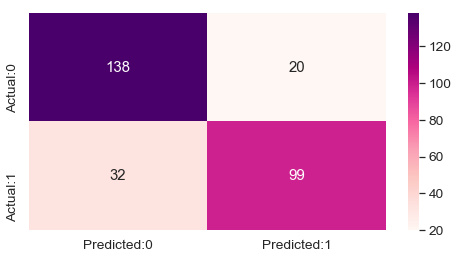

In [46]:
cm=confusion_matrix(y_test,prediction_grid)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="RdPu")

### Visualizando a correlação entre as variáveis

Coeficiente de correlação:

+1 = forte correlação positiva

0 = não há correlação

-1 = forte correlação negativa

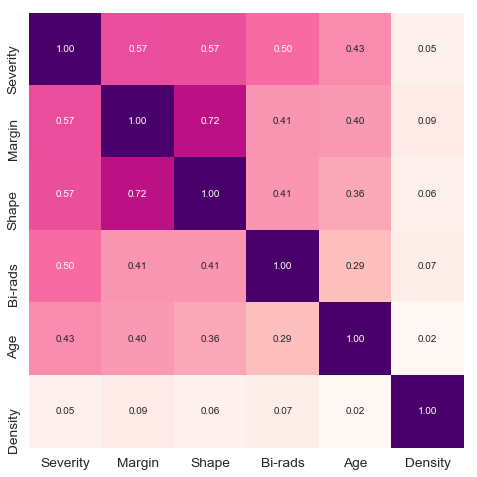

In [51]:
k = 6 #número de variáveis para o heatmap
corrmat = df.corr() #correlação
cols = corrmat.nlargest(k, 'Severity')['Severity'].index
tab = np.corrcoef(df[cols].values.T) 

plt.figure(figsize=(8,8))
sns.set(font_scale=1.25)
sns.heatmap(tab, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values, cmap="RdPu")
plt.show()

In [52]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

In [53]:
results = [
    ['The acuracy of the model = TP+TN/(TP+TN+FP+FN) = ', (TP+TN)/float(TP+TN+FP+FN)],
    ['The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN))],
    ['Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN)],
    ['Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP)],
    ['Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP)],
    ['Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN)],
    ['Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity)],
    ['Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/(specificity)],    
]
tbl.make_table(results)

The acuracy of the model = TP+TN/(TP+TN+FP+FN) =,0.8201
The Missclassification = 1-Accuracy =,0.1799
Sensitivity or True Positive Rate = TP/(TP+FN) =,0.7557
Specificity or True Negative Rate = TN/(TN+FP) =,0.8734
Positive Predictive value = TP/(TP+FP) =,0.8319
Negative predictive Value = TN/(TN+FN) =,0.8118
Positive Likelihood Ratio = Sensitivity/(1-Specificity) =,5.9702
Negative likelihood Ratio = (1-Sensitivity)/Specificity =,0.2797


#### Curva ROC - True positive, false positive 

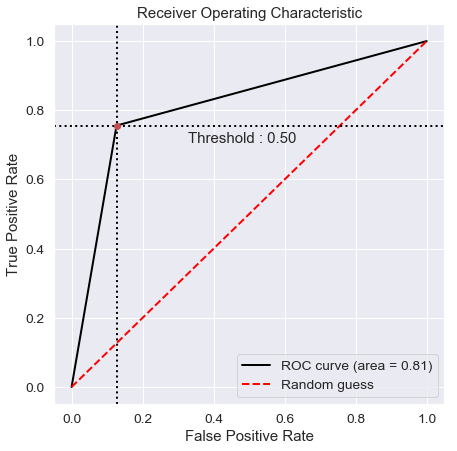

In [54]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test, prediction_grid, labels=["Class 1", "Class 2"])
# Figures
plt.figure(figsize=(7,7))
bc.plot_roc_curve()
plt.show()

## 7 - Conclusão

- A variável "Margin" e "Shape" tiveram a maior correlação entre si, e a "Margin" a maior correlação com a minha classe preditora "Severity".


- O modelo obteve uma acurácia de 81 % utilizando o SVM. A acurácia de predição teve uma sutil melhora com a utilização do GridSearchCV e passou a ser de 82,01%.


- A sensitividade é muito importante nesse tipo de análise, pois é o verdadeiro positivo. Sua acurácia foi de 75,34%.